# Getting started

In [80]:
### Load packages
library(data.table)
library(readxl)
library(stringr)
library(dplyr)
library(forecast)
library(ggplot2)
library(tseries)
library(stats)
library(psych)
library(fUnitRoots)
library(lmtest)
library(pastecs)
library(FitAR)
library(aTSA)
library(itsmr)
library(pracma)
library(arfima)
library(dse)
library(smooth)
library(fGarch)

In [81]:
list.files(pattern = ".csv")

[1] "^BSESN.csv"    "^GSPC.csv"     "^HSI.csv"      "^JKSE.csv"    
 [5] "^MERV.csv"     "^N225.csv"     "^NSEI.csv"     "^NZ50.csv"    
 [9] "^STOXX50E.csv" "000001.SS.csv"

# Stock 2 
## About S&P/NZX 50 Gross Index
Contrasting to HSI, NZ50 is only having a 49,914,886 30 day average volume. It is believed that it is a less efficient market, thus may show more autocorrelation in data.
## NZ50 – Data Exploration

In [82]:
# Load data

df = read.csv('^NZ50.csv')
df %>% setDT
df = df[,.(date = as.Date(Date),
                 Price = Adj.Close%>% as.character %>% as.numeric)]
df = df[date>='2019-05-04' & date <= '2020-05-08',]
df = na.omit(df)
setkey(df, date)
df %>% tail

Warning message in function_list[[k]](value):
"NAs introduced by coercion"


date,Price
<date>,<dbl>
2020-05-01,10449.01
2020-05-04,10516.09
2020-05-05,10551.16
2020-05-06,10596.77
2020-05-07,10676.25
2020-05-08,10695.59


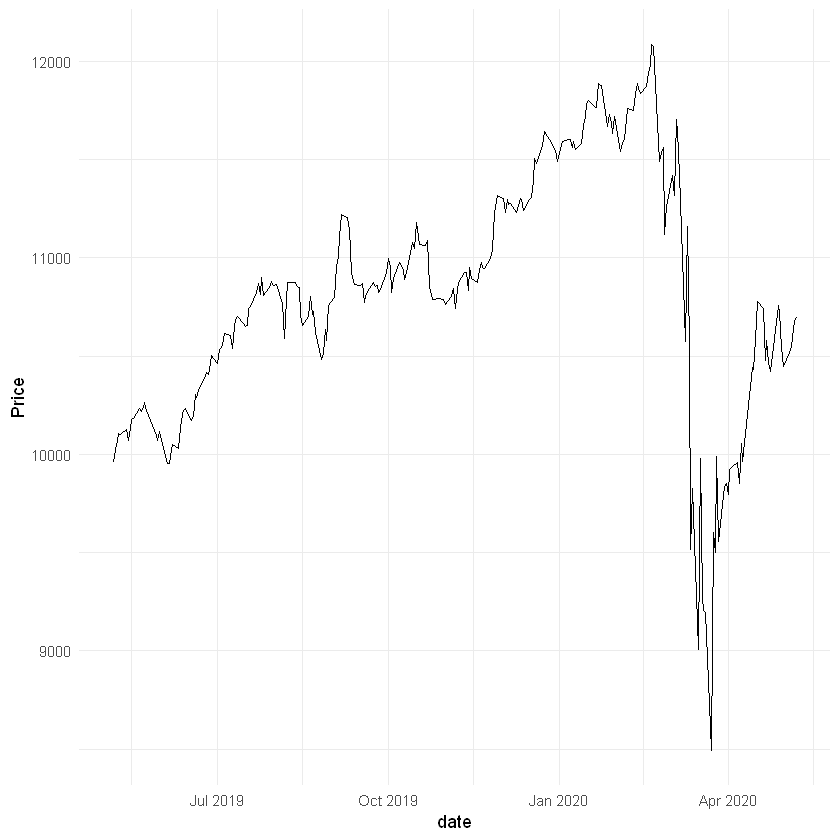

In [83]:
# Graph of the index

ggplot(df, aes(x=date)) + geom_line(aes(y=Price,group=1))+ theme_minimal()

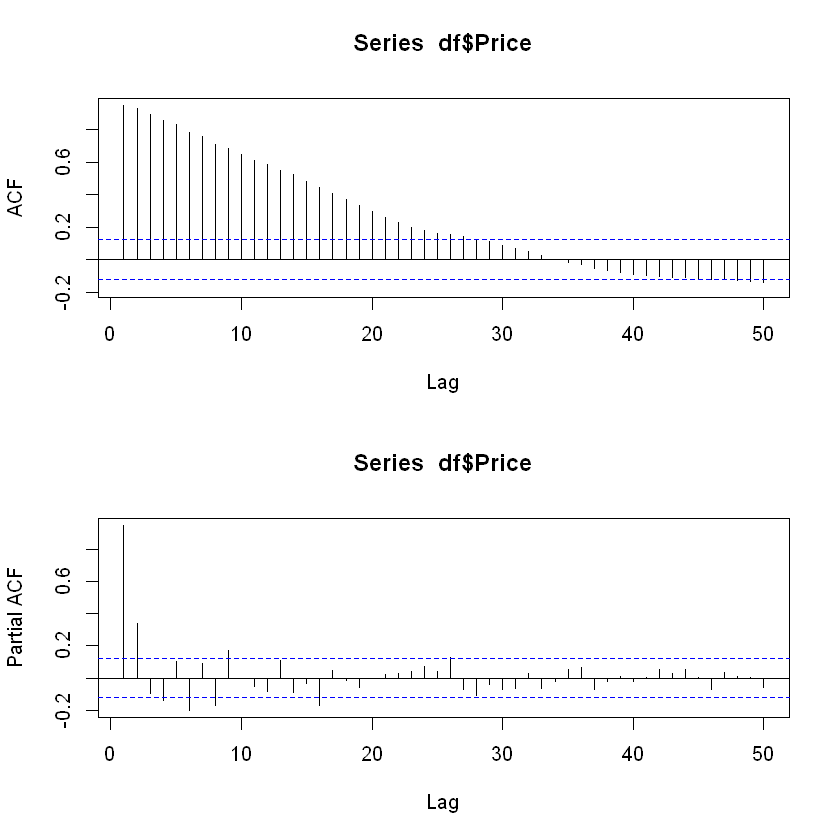

In [84]:
# ACFs and PACFs 
par(mfrow=c(2,1))

Acf(df$Price, lag.max = 50)

Pacf(df$Price, lag.max = 50)

In [85]:
# Augmented Dickey-Fuller Test

aTSA::adf.test(df$Price, nlag = NULL, output = TRUE)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 0.0866   0.669
[2,]   1 0.2189   0.707
[3,]   2 0.1659   0.692
[4,]   3 0.1010   0.673
[5,]   4 0.1445   0.685
Type 2: with drift no trend 
     lag   ADF p.value
[1,]   0 -2.71  0.0785
[2,]   1 -1.96  0.3451
[3,]   2 -2.07  0.3001
[4,]   3 -2.32  0.2001
[5,]   4 -2.10  0.2876
Type 3: with drift and trend 
     lag   ADF p.value
[1,]   0 -2.65   0.303
[2,]   1 -1.81   0.655
[3,]   2 -1.96   0.594
[4,]   3 -2.26   0.468
[5,]   4 -2.00   0.577
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


From the graph and ACF plot, we can see the persistence of the price is very high. It brings the question whether it is nonstationary. Checking with Augmented Dickey-Fuller test, the p-values are all greater than 0.05, meaning we fail to reject the null hypothesis that the time series is non-stationary and unit root exists. So, we need to use log differences to make it mean stationary:
$R_t = log(P_t) - log(P_{t-1})$

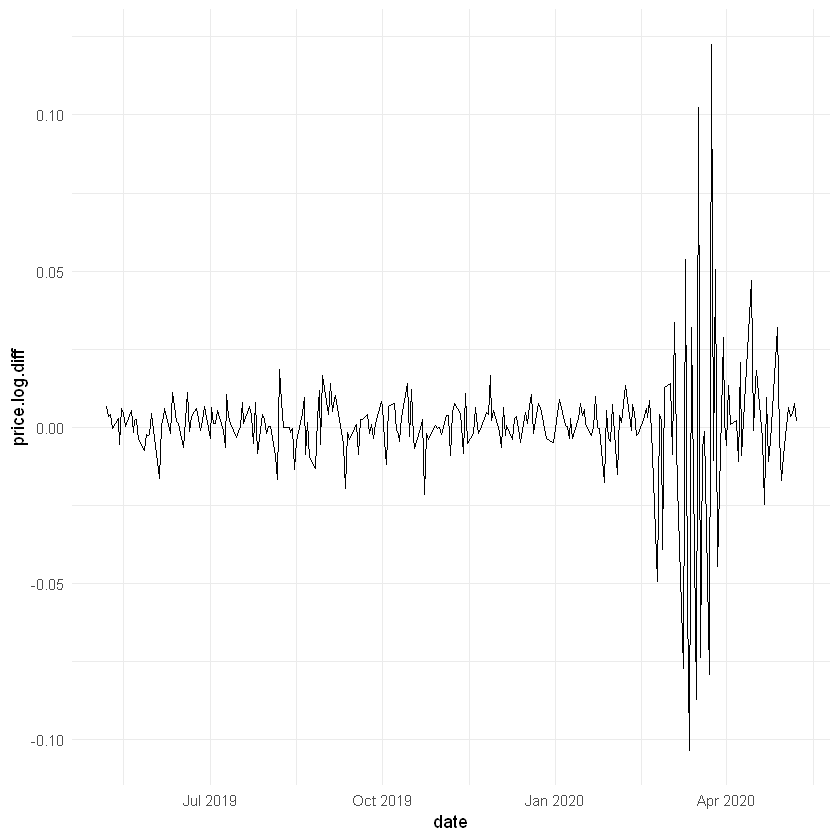

In [86]:
df[, price.lag.1:= shift(Price, type = 'lag', n=1) ]
df[, price.log.diff := log(Price) - log(price.lag.1)]
df = na.omit(df)
ggplot(df, aes(x=date)) + geom_line(aes(y=price.log.diff,group=1))+ theme_minimal() 

In [87]:
# Descriptive statistics 

stat.desc(df$price.log.diff)

nbr.val      nbr.null        nbr.na           min           max 
 2.540000e+02  0.000000e+00  0.000000e+00 -1.033731e-01  1.225738e-01 
        range           sum        median          mean       SE.mean 
 2.259469e-01  7.119216e-02  1.126160e-03  2.802841e-04  1.212098e-03 
 CI.mean.0.95           var       std.dev      coef.var 
 2.387088e-03  3.731722e-04  1.931767e-02  6.892173e+01

In [88]:
getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}
getmode(df$price.log.diff)

[1] 0.006680983

In [89]:
kurtosis(df$price.log.diff)

[1] 15.64866
attr(,"method")
[1] "excess"

In [90]:
skewness(df$price.log.diff)

[1] -0.124373
attr(,"method")
[1] "moment"

, , 1

              [,1]
 [1,]  1.000000000
 [2,] -0.412021525
 [3,]  0.244177231
 [4,] -0.009788886
 [5,] -0.150118878
 [6,]  0.312328181
 [7,] -0.306562164
 [8,]  0.331302864
 [9,] -0.315205839
[10,]  0.100788731
[11,]  0.025563572
[12,] -0.063469503
[13,]  0.042945614
[14,] -0.065215557
[15,]  0.095383809
[16,] -0.004553665
[17,] -0.008713534
[18,] -0.011609944
[19,]  0.015631439
[20,] -0.055841997
[21,]  0.033585235
[22,] -0.078600158
[23,] -0.014626862
[24,] -0.076944672
[25,] -0.026928256
[26,] -0.049289920
[27,]  0.001197981
[28,]  0.082199636
[29,] -0.059287999
[30,]  0.097129224
[31,] -0.048568624
[32,]  0.008080045
[33,]  0.050391140
[34,] -0.004281101
[35,] -0.006640328
[36,] -0.071105888
[37,]  0.068095618
[38,] -0.056649983
[39,] -0.003713390
[40,]  0.015093773
[41,] -0.060875871
[42,] -0.004541033
[43,] -0.008426914
[44,]  0.004448639
[45,] -0.009165342
[46,]  0.020985301
[47,] -0.002607815
[48,]  0.019445398
[49,] -0.026958053
[50,]  0.024720159
[51,]  0.001756826

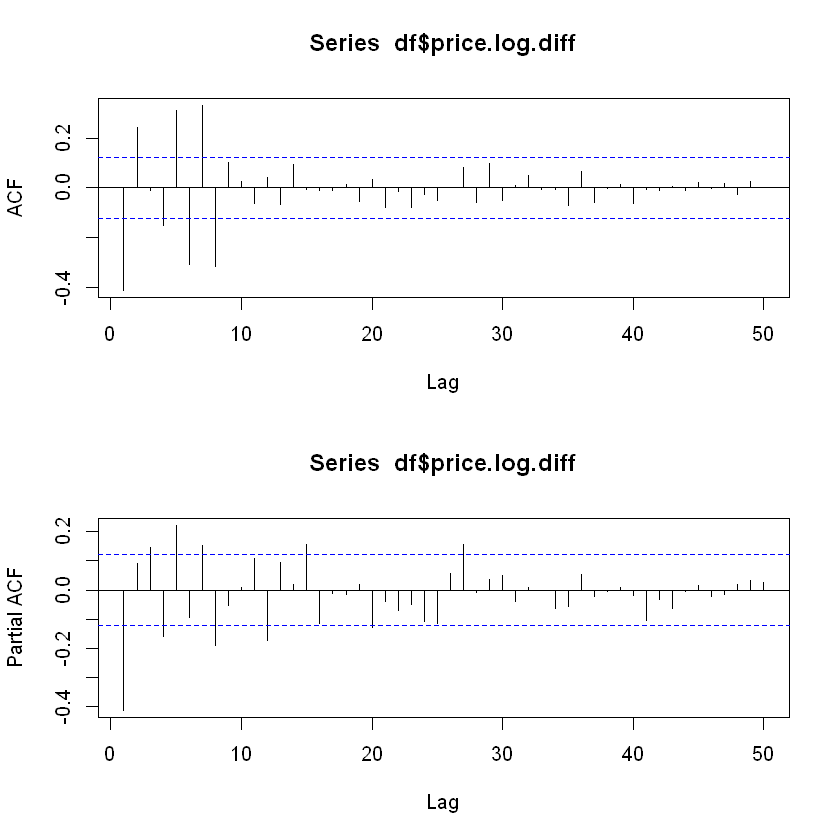

In [91]:
# ACFs and PACFs 
par(mfrow=c(2,1))

acf = Acf(df$price.log.diff, lag.max = 50)
acf$acf

Pacf(df$price.log.diff, lag.max = 50)

In [92]:
# Augmented Dickey-Fuller Test

aTSA::adf.test(df$price.log.diff, nlag = NULL, output = TRUE)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -24.60    0.01
[2,]   1 -12.14    0.01
[3,]   2  -8.29    0.01
[4,]   3  -8.59    0.01
[5,]   4  -5.99    0.01
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -24.56    0.01
[2,]   1 -12.12    0.01
[3,]   2  -8.28    0.01
[4,]   3  -8.57    0.01
[5,]   4  -5.98    0.01
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -24.55    0.01
[2,]   1 -12.13    0.01
[3,]   2  -8.28    0.01
[4,]   3  -8.59    0.01
[5,]   4  -5.98    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


The return seems mean stationary, however, is obviously variance non-stationary from the plot. From the Augmented Dickey-Fuller test , the coefficients are all negative in the three types of test, and the p-value is smaller than 0.01, indicating the data do not have unit root and is covariance stationary. From the ACF graph, it has spikes on the first few lags, and then a decay toward zero; PACF shows splike from first lag and a smooth decay toward zero. These are signs that the time zeries may be an ARMA process.

## Model Selection

In [93]:
# prepare ts data

df.ts = df[ date < '2020-05-04', list(date, price.log.diff)] 
tsdata = ts(df.ts$price.log.diff, start = df$date[1], frequency = 365)
print(paste("Number of observations:",length(tsdata)))

[1] "Number of observations: 249"


In [94]:
#  fitting different ARMA models and compare with AIC

auto.arima(tsdata, trace=TRUE)


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2)             with non-zero mean : -1327.669
 ARIMA(0,0,0)             with non-zero mean : -1251.14
 ARIMA(1,0,0)             with non-zero mean : -1294.763
 ARIMA(0,0,1)             with non-zero mean : -1282.902
 ARIMA(0,0,0)             with zero mean     : -1253.148
 ARIMA(1,0,2)             with non-zero mean : -1296.429
 ARIMA(2,0,1)             with non-zero mean : -1293.807
 ARIMA(3,0,2)             with non-zero mean : -1331.181
 ARIMA(3,0,1)             with non-zero mean : -1331.468
 ARIMA(3,0,0)             with non-zero mean : -1296.21
 ARIMA(4,0,1)             with non-zero mean : -1329.683
 ARIMA(2,0,0)             with non-zero mean : -1293.813
 ARIMA(4,0,0)             with non-zero mean : -1299.713
 ARIMA(4,0,2)             with non-zero mean : -1327.752
 ARIMA(3,0,1)             with zero mean     : -1333.553
 ARIMA(2,0,1)             with zero mean     : -1295.877
 ARIMA(3,0,0)             wit

Series: tsdata 
ARIMA(3,0,1) with zero mean 

Coefficients:
          ar1      ar2    ar3     ma1
      -1.1728  -0.1242  0.275  0.9262
s.e.   0.0638   0.0968  0.062  0.0254

sigma^2 estimated as 0.000267:  log likelihood=672.45
AIC=-1334.9   AICc=-1334.65   BIC=-1317.31

Using AIC as model selection criterion, the best model estimated is ARMA(3,1)

#### ARMA(3,1)
$R_t = \delta + \varphi_1 R_{t-1} +\varphi_2 R_{t-2} +\varphi_3 R_{t-3} + \varepsilon_t + \theta \varepsilon_{t-1}$

In [95]:
fitARIMA <- arima(tsdata, order=c(3,0,1),method="ML")
coeftest(fitARIMA)


z test of coefficients:

             Estimate  Std. Error  z value  Pr(>|z|)    
ar1       -1.17306032  0.06384683 -18.3730 < 2.2e-16 ***
ar2       -0.12464305  0.09684232  -1.2871    0.1981    
ar3        0.27479133  0.06198933   4.4329 9.298e-06 ***
ma1        0.92620773  0.02541507  36.4433 < 2.2e-16 ***
intercept  0.00018827  0.00097931   0.1923    0.8475    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Although ARMA(3,1) has the lowest AIC. From the plot, all roots of characteristic polynomial lie inside unit circle and thus it is stationary and invertible. However, not all its coefficients are statistically significant. Therefore, we would take a look at other models with comparable AIC.

#### ARMA(2,2)
$R_t = \delta + \varphi_1 R_{t-1} +\varphi_2 R_{t-2} + \varepsilon_t + \theta_1 \varepsilon_{t-1}+ \theta_2 \varepsilon_{t-2}$

In [96]:
fitARIMA <- arima(tsdata, order=c(2,0,2),method="ML")
coeftest(fitARIMA)


z test of coefficients:

             Estimate  Std. Error  z value  Pr(>|z|)    
ar1       -1.66567942  0.05823392 -28.6033 < 2.2e-16 ***
ar2       -0.81154472  0.05377596 -15.0912 < 2.2e-16 ***
ma1        1.42053031  0.08823512  16.0994 < 2.2e-16 ***
ma2        0.47108322  0.08484572   5.5522  2.82e-08 ***
intercept  0.00020262  0.00085506   0.2370    0.8127    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


All coefficients are statistically significant.

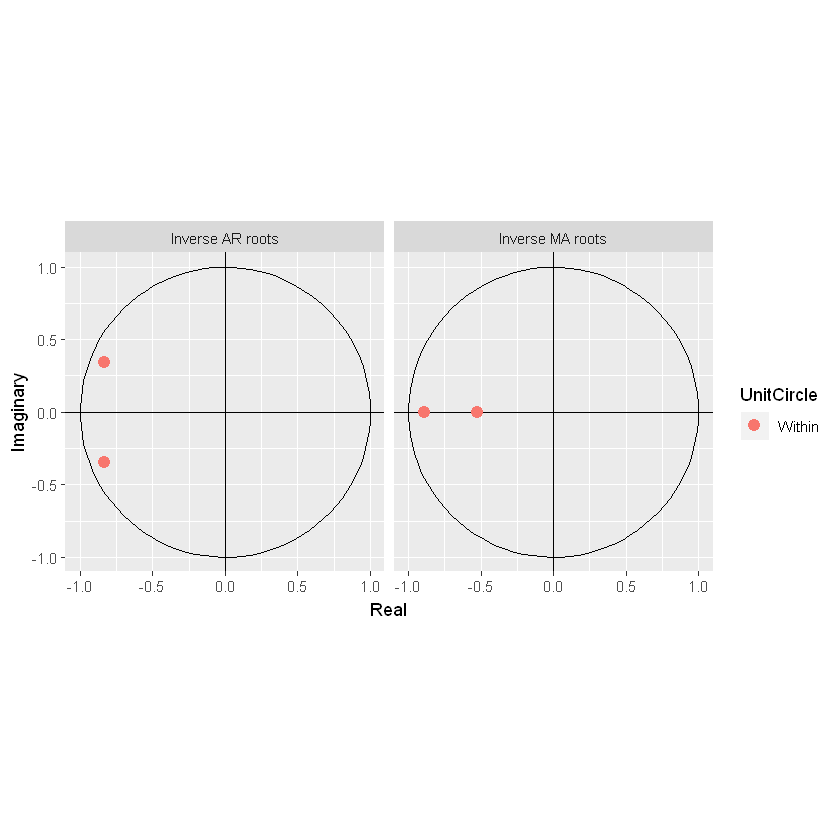

In [97]:
autoplot(fitARIMA)

All roots lie inside unit circle, showing the model is stationary and invertible.


	Ljung-Box test

data:  Residuals from ARIMA(2,0,2) with non-zero mean
Q* = 43.438, df = 45, p-value = 0.5383

Model df: 5.   Total lags used: 50



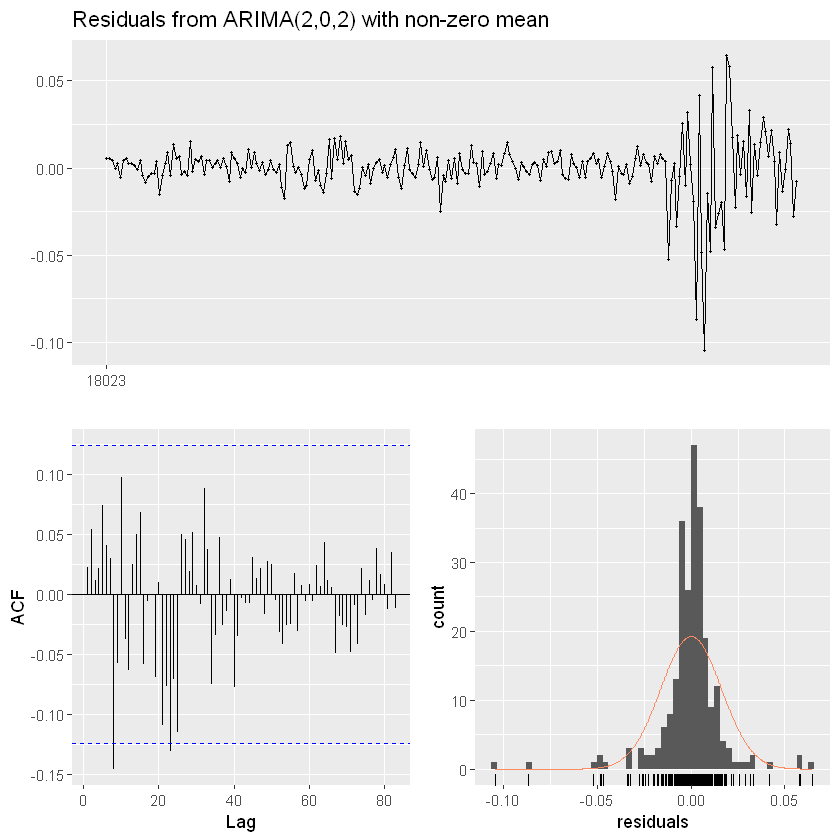

In [98]:
checkresiduals(fitARIMA)

Since p-value > 0.05, we fail to reject the null hypothesis that all autocorrelations up to order 50 are equal to zero, meaning the residuals are independent at 95% level. Thus, ARMA(2,2) is a good fit as the residuals are seemingly white noise. However, it is obvious from the plot that the residuals have time-varying volatility.

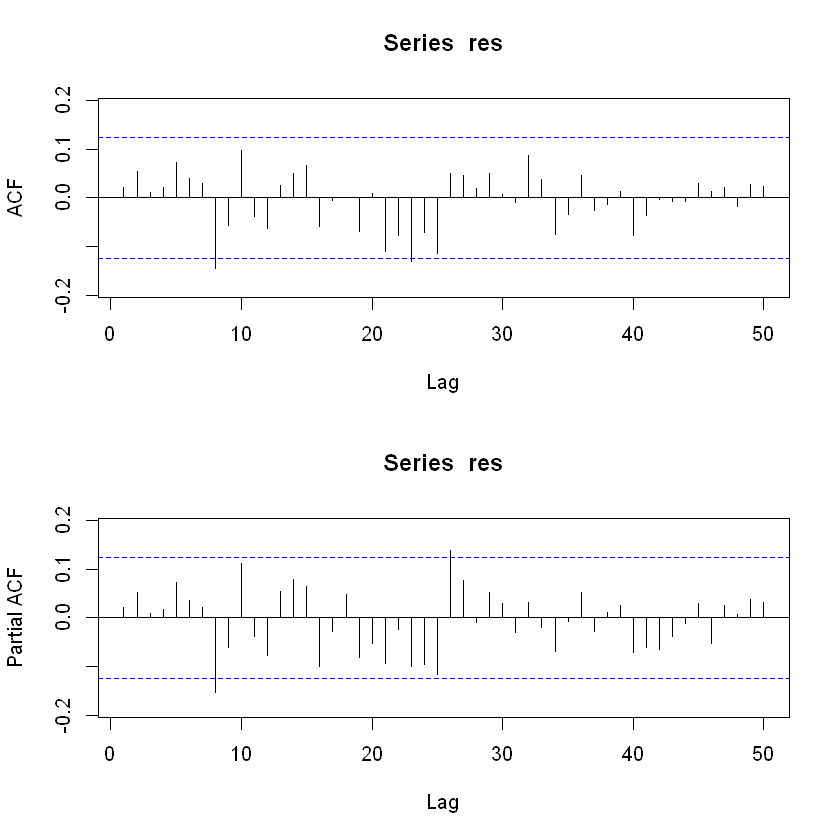

In [99]:
res = residuals(fitARIMA)
# ACFs and PACFs  of residuals 
par(mfrow=c(2,1))

Acf(res, lag.max = 50)

Pacf(res, lag.max = 50)

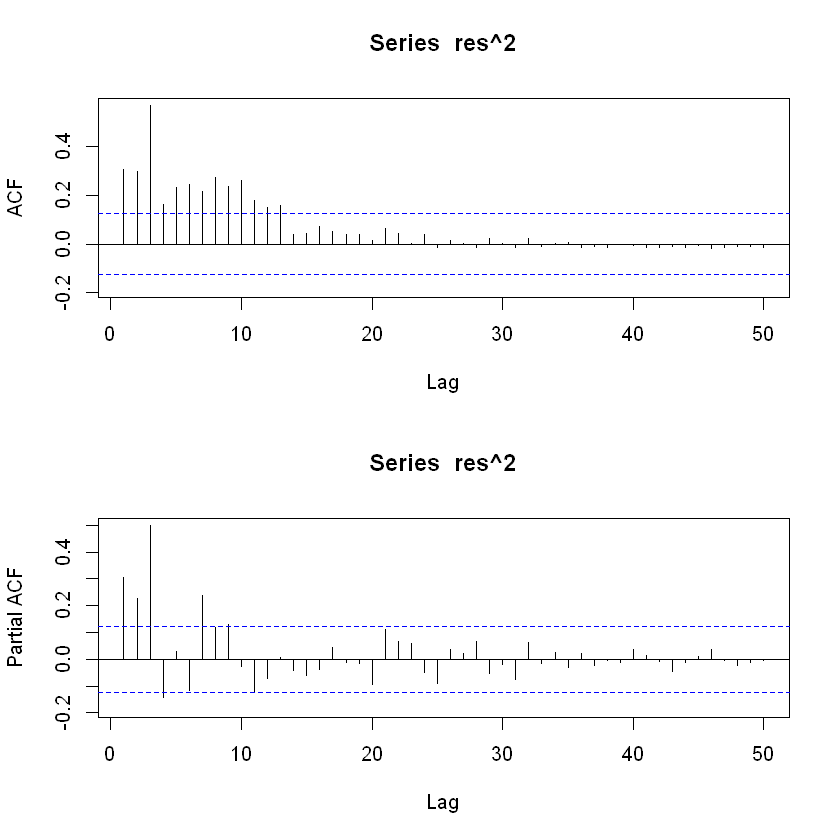

In [100]:
res = residuals(fitARIMA)
# ACFs and PACFs  of residuals 
par(mfrow=c(2,1))

Acf(res^2, lag.max = 50)

Pacf(res^2, lag.max = 50)

From the ACF and PACF plot of squared residuals, we can see the residuals exhibit time-varying volatility as it has autocorrelations with high persistence form the ACF plot with some spikes up to lag 10. Therefore, we would use GARCH model to predict the volatility.

## Forecast with rolling scheme

#### Forecast for May 4:

In [62]:
df.ts = df[ date < '2020-05-04', list(date, price.log.diff)]
tsdata = ts(df.ts$price.log.diff, start = df$date[1], frequency = 365)
fitARIMA <- arima(tsdata, order=c(2,0,2),method="ML", include.mean = TRUE)
# fitARIMA <- arima(tsdata, order=c(3,0,1),method="ML", include.mean = TRUE)
predict(fitARIMA, n.ahead=1)

$pred
Time Series:
Start = c(18023, 250) 
End = c(18023, 250) 
Frequency = 365 
[1] 0.005384866

$se
Time Series:
Start = c(18023, 250) 
End = c(18023, 250) 
Frequency = 365 
[1] 0.01617198

$R_{t+1}=\delta+\varphi_1R_{t}+\varphi_2R_{t-1}+\varepsilon_t+\theta_1\varepsilon_{t}+\theta_2\varepsilon_{t-1}$

In [63]:
# Manual calculation of one-step ahead forecast for May 4:
ar1 = coef(fitARIMA)['ar1']
ar2 = coef(fitARIMA)['ar2']
# ar3 = coef(fitARIMA)['ar3']
ma1 = coef(fitARIMA)['ma1']
ma2 = coef(fitARIMA)['ma2']
mu = coef(fitARIMA)['intercept']
y.series = df.ts$price.log.diff
y.t = y.series[length(y.series)-0]
y.t.1 = y.series[length(y.series)-1]
# y.t.2 = y.series[length(y.series)-2]
res = residuals(fitARIMA)
eps.t = res[length(res)-0]
eps.t.1 = res[length(res)-1]
f.1 = mu + ar1 * (y.t-mu) + ar2 * (y.t.1-mu) + ma1 * eps.t + ma2 * eps.t.1
f.1.4 = f.1
print(paste("The one-step ahead forecast is: ",f.1))

[1] "The one-step ahead forecast is:  0.00538486581613136"


In [64]:
y.truth = df[date == "2020-05-04", list(date, price.log.diff)]$price.log.diff
y.4 = y.truth
print(paste("The truth value is: ",y.truth))
eps.t.update = y.truth - f.1
e.4 = eps.t.update
print(paste("The forecast error is:", eps.t.update))

[1] "The truth value is:  0.00639923569738876"
[1] "The forecast error is: 0.0010143698812574"



Call:
garch(x = y, order = c(1, 1), trace = FALSE)

Model:
GARCH(1,1)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.6059 -0.4830  0.1643  0.5865  1.9551 

Coefficient(s):
    Estimate  Std. Error  t value Pr(>|t|)    
a0 8.276e-06   3.139e-06    2.636  0.00838 ** 
a1 1.034e-01   2.972e-02    3.481  0.00050 ***
b1 8.139e-01   5.960e-02   13.656  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Diagnostic Tests:
	Jarque Bera Test

data:  Residuals
X-squared = 801.26, df = 2, p-value < 2.2e-16


	Box-Ljung test

data:  Squared.Residuals
X-squared = 0.056589, df = 1, p-value = 0.812


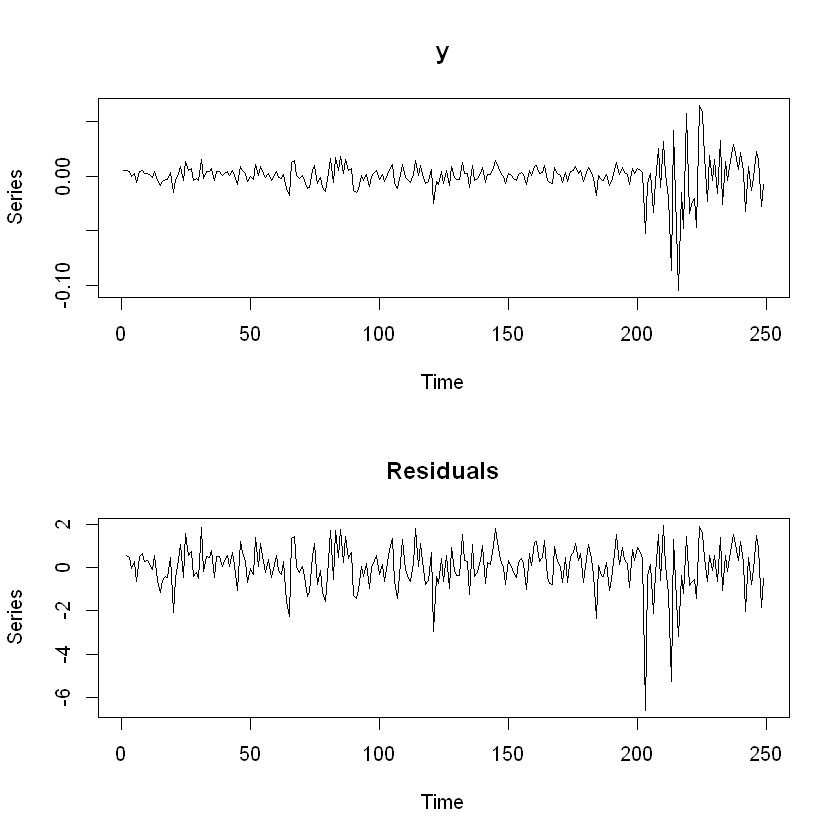

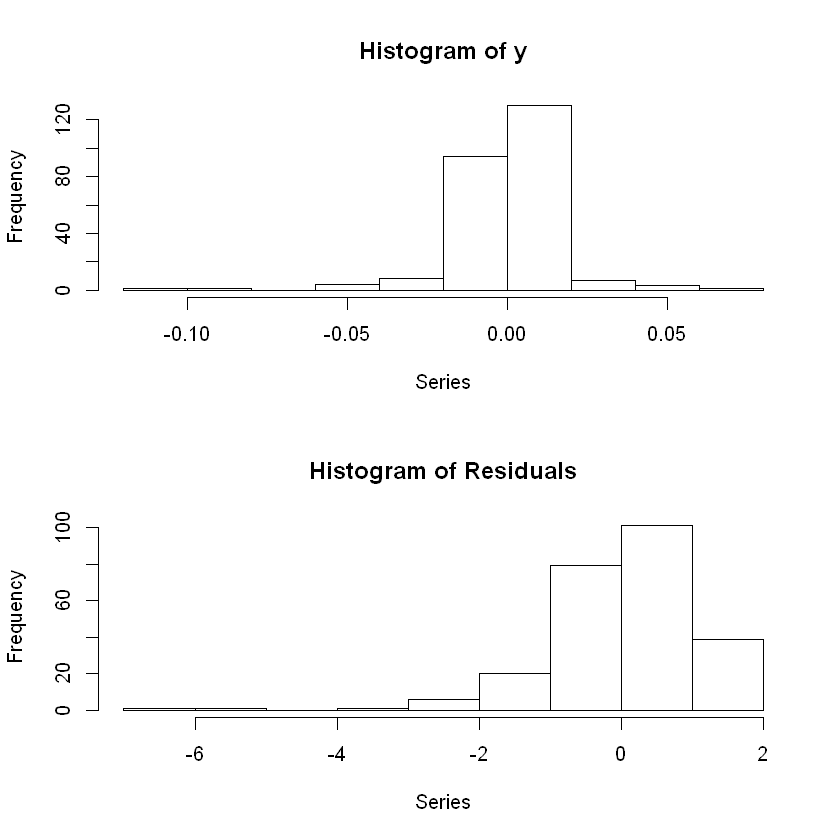

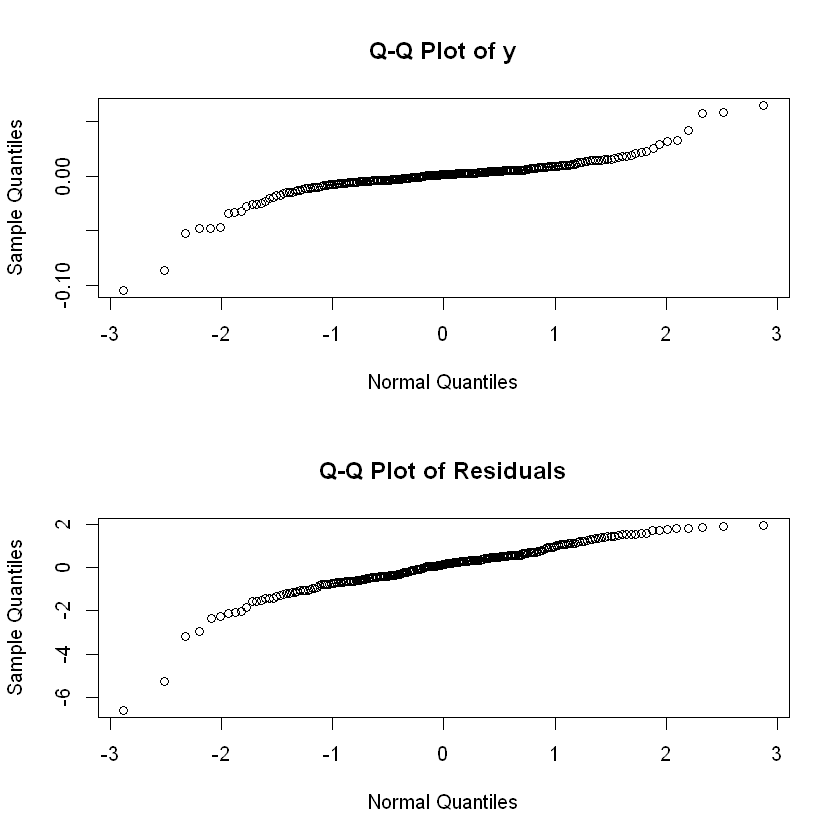

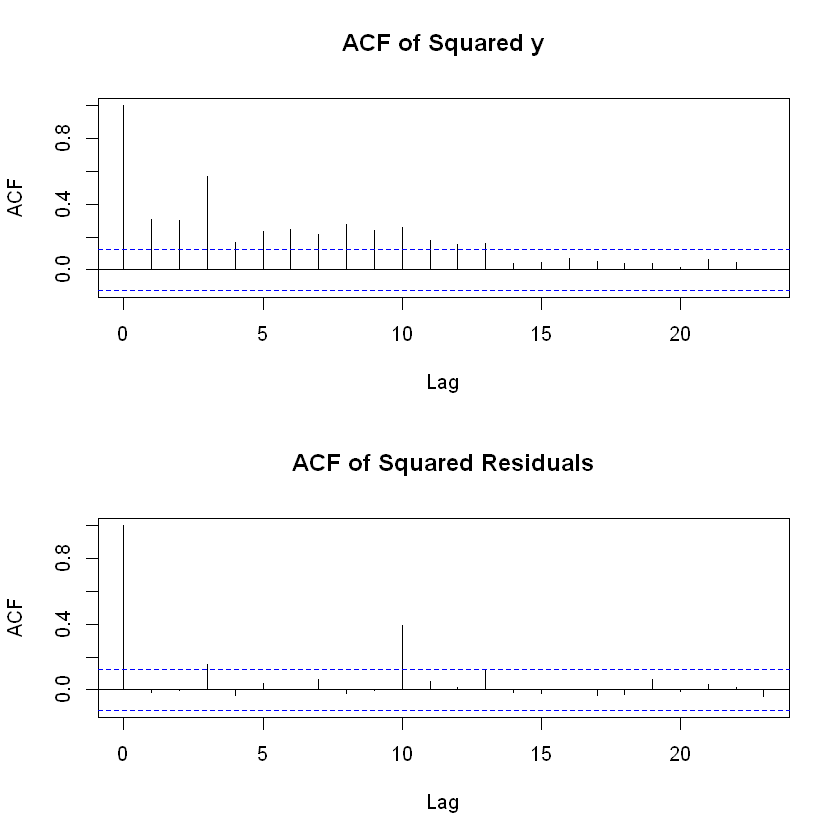

In [65]:
y <- ts(res)
garch.y <- garch(y, order = c(1,1), trace=FALSE)  # Fit GARCH(1,1)
summary(garch.y)                     # Diagnostic tests

plot(garch.y)

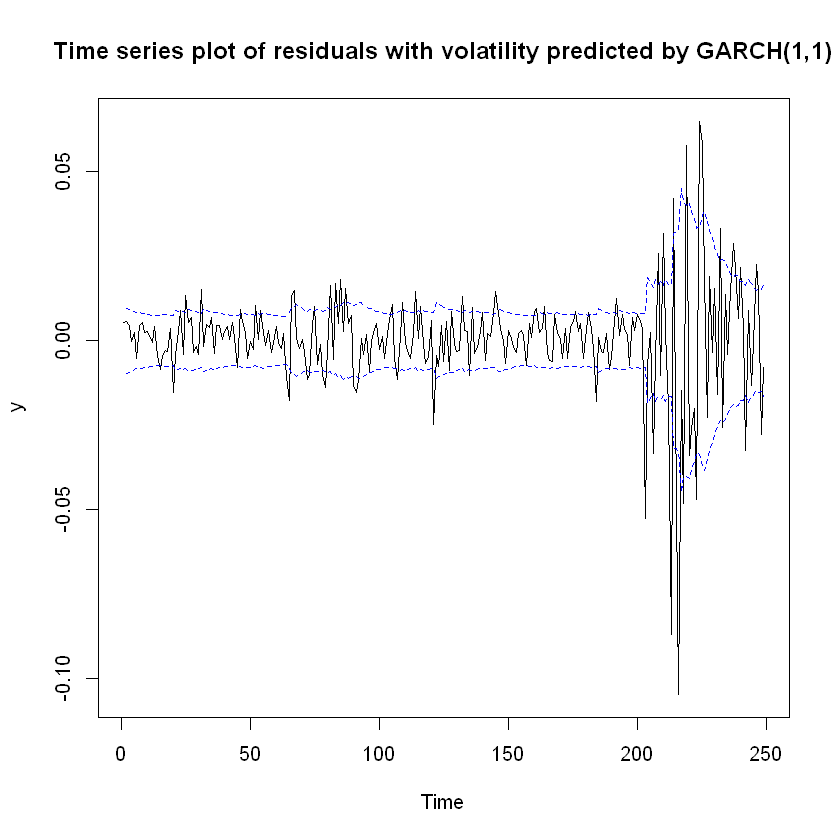

In [66]:
u = predict(garch.y)
u = u %>% na.omit
plot(y, type="l", xlab="Time", main = "Time series plot of residuals with volatility predicted by GARCH(1,1)")
lines(u[,1], col="blue", lty="dashed")
lines(u[,2], col="blue", lty="dashed")

In [67]:
fit = garchFit(formula~ garch(1,1), data=y,
                        trace=F) 
omega = coef(fit)[2]
print(paste("omega:",omega))
alpha = coef(fit)[3]
print(paste("alpha",alpha))
beta = coef(fit)[4]
print(paste("beta",beta))
sigma.t = last(volatility(fit))
print(paste("sigma_{t|t-1}:",sigma.t))
epsilon.t = last(residuals(fit))
print(paste("epsilon_t:",epsilon.t))
sigma = omega + alpha * (epsilon.t)^2 + beta * (sigma.t)^2
s.4 = sigma^(1/2)
print(paste('1 step ahead forecast sigma:',sigma^(1/2)))

[1] "omega: 8.01794395483014e-06"
[1] "alpha 0.21193207718508"
[1] "beta 0.757502059125593"
[1] "sigma_{t|t-1}: 0.0196626869690167"
[1] "epsilon_t: -0.00797343094436574"
[1] "1 step ahead forecast sigma: 0.0177301453127844"


In [68]:
garch.y.fit = garchFit(formula~ garch(1,1), data=y,
                        trace=F) 
vol.pred = predict(garch.y.fit, n.ahead = 1)
vol.pred

meanForecast,meanError,standardDeviation
<dbl>,<dbl>,<dbl>
1.534721e-05,0.01773015,0.01773015


In [69]:
lower.ci = f.1 - 1.96 * sigma^(1/2)
upper.ci = f.1 + 1.96 * sigma^(1/2)
print(paste('Prediction lower bound:',lower.ci))
print(paste('Prediction upper bound:',upper.ci))
print(paste("The truth value is: ",y.truth))

[1] "Prediction lower bound: -0.0293662189969261"
[1] "Prediction upper bound: 0.0401359506291889"
[1] "The truth value is:  0.00639923569738876"


#### Forecast for May 4 to 8:

In [70]:
begin.dates = c("2019-05-03", "2019-05-04", "2019-05-05", "2019-05-06", "2019-05-07")
end.dates = c("2020-05-04", "2020-05-05", "2020-05-06", "2020-05-07", "2020-05-08")
forecasts = rep(1:5)
prog.forecasts = rep(1:5)
sigma = rep(1:5)
prog.sigma = rep(1:5)
real.ret = df[ date >= "2020-05-04" & date <= "2020-05-08", list(date, price.log.diff)]

for( i in 1:5){
    df.ts = df[ date >= begin.dates[i] & date < end.dates[i], list(date, price.log.diff)]
    tsdata = ts(df.ts$price.log.diff, start = df$date[1], frequency = 365)
    fitARIMA <- arima(tsdata, order=c(2,0,2),method="ML", include.mean = TRUE)
    prog.forecasts[i] = predict(fitARIMA, n.ahead=1)$pred

    # Manual calculation of one-step ahead forecast:
    ar1 = coef(fitARIMA)['ar1']
    ar2 = coef(fitARIMA)['ar2']
    # ar3 = coef(fitARIMA)['ar3']
    ma1 = coef(fitARIMA)['ma1']
    ma2 = coef(fitARIMA)['ma2']
    mu = coef(fitARIMA)['intercept']
    y.series = df.ts$price.log.diff
    y.t = y.series[length(y.series)-0]
    y.t.1 = y.series[length(y.series)-1]
    # y.t.2 = y.series[length(y.series)-2]
    res = residuals(fitARIMA)
    eps.t = res[length(res)-0]
    eps.t.1 = res[length(res)-1]
    forecasts[i] = mu + ar1 * (y.t-mu) + ar2 * (y.t.1-mu) + ma1 * eps.t + ma2 * eps.t.1

    # Variance forecast
    res = residuals(fitARIMA)
    y <- ts(res)

    fit = garchFit(formula~ garch(1,1), data=y,
                    trace=F) 
    omega = coef(fit)[2]
#     print(paste("omega:",omega))
    alpha = coef(fit)[3]
#     print(paste("alpha",alpha))
    beta = coef(fit)[4]
#     print(paste("beta",beta))
    sigma.t = last(volatility(fit))
#     print(paste("sigma_{t|t-1}:",sigma.t))
    epsilon.t = last(residuals(fit))
#     print(paste("epsilon_t:",epsilon.t))
    sigma[i] = sqrt(omega + alpha * (epsilon.t)^2 + beta * (sigma.t)^2)

    prog.sigma[i] = predict(fit, n.ahead = 1)$standardDeviation        
}

In [75]:
df.est = data.table(real.ret)
df.est[, forecast := forecasts]
df.est[, prog.forecast := prog.forecasts]
df.est[, sigma := sigma]
df.est[, prog.sigma:=prog.sigma]
df.est[, upper.ci := forecast + 1.96*sigma]
df.est[, lower.ci := forecast - 1.96*sigma]
df.est[, error := price.log.diff	 - forecast]
df.est[, rsq.error := error^2%>%sqrt]
df.est[, abs.error := abs(error)]

df.est

date,price.log.diff,forecast,prog.forecast,sigma,prog.sigma,upper.ci,lower.ci,error,rsq.error,abs.error
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-05-04,0.006399236,0.0053848658,0.0053848658,0.01773015,0.01773015,0.04013595,-0.02936622,0.001014370,0.001014370,0.001014370
2020-05-05,0.003329371,-0.0048296887,-0.0048296887,0.01561543,0.01561543,0.02577655,-0.03543592,0.008159060,0.008159060,0.008159060
2020-05-06,0.004313372,0.0020585630,0.0020585630,0.01429396,0.01429396,0.03007473,-0.02595760,0.002254809,0.002254809,0.002254809
2020-05-07,0.007472455,-0.0020528736,-0.0020528736,0.01268188,0.01268188,0.02280362,-0.02690936,0.009525328,0.009525328,0.009525328
2020-05-08,0.001809844,-0.0004967034,-0.0004967034,0.01211624,0.01211624,0.02325112,-0.02424452,0.002306548,0.002306548,0.002306548


In [76]:
rmse = mean(df.est$rsq.error) 
print(paste("RMSE: ", rmse))
mae = mean(df.est$abs.error)
print(paste("MAE: ", mae))

[1] "RMSE:  0.00465202292077624"
[1] "MAE:  0.00465202292077624"


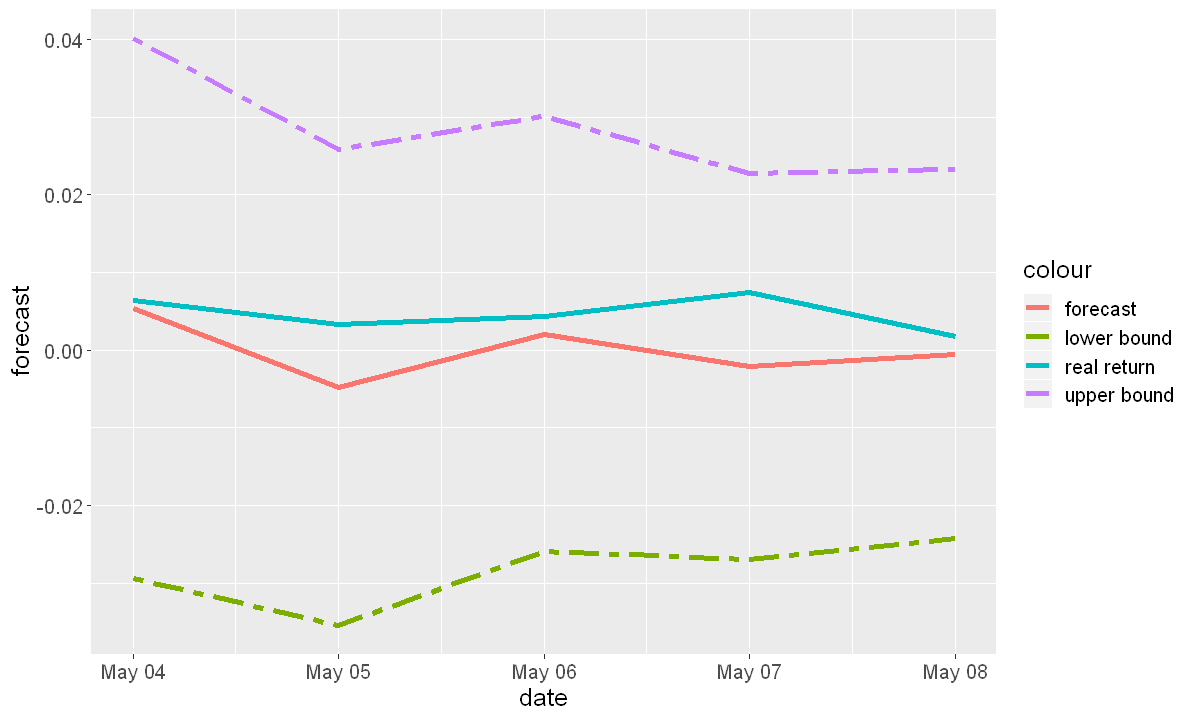

In [73]:
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}
fig(10,6)
ggplot(data = df.est , aes(x=date))+
    geom_line(aes(y = forecast, color = "forecast"),lwd=1.5) +
    geom_line(aes(y = price.log.diff, color = "real return"),lwd=1.5) +
    geom_line(aes(y = lower.ci, color = "lower bound"), linetype = "twodash",lwd=1.5) +
    geom_line(aes(y = upper.ci, color = "upper bound"), linetype = "twodash",lwd=1.5) +
    theme(text = element_text(size=15)) +
    scale_size_manual( values = c(4,2,2) )